In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

DATA_DIR = "/content/drive/MyDrive/data"
SELECTED_ACTIVITIES = ["sit", "walk", "run", "stairs"]
SELECTED_POSITIONS = ["dom_hand", "nondom_hand", "dom_pocket", "nondom_pocket", "backpack"]

SAMPLING_RATE = 100
TRIM_SECONDS = 2
WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2

BATCH_SIZE = 32
EPOCHS = 100
LR = 0.001
DROPOUT = 0.3
RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_g", "ay_g", "az_g", "gx_g", "gy_g", "gz_g"]

In [3]:
def load_selected_csvs(base_dir):
    dfs = []
    for activity in SELECTED_ACTIVITIES:
        for position in SELECTED_POSITIONS:
            for csv_path in glob.glob(os.path.join(base_dir, activity, position, "*.csv")):
                df = pd.read_csv(csv_path)
                df["activity"] = activity
                df["phone_position"] = position
                df["recording_id"] = os.path.splitext(os.path.basename(csv_path))[0]
                dfs.append(df)
    print(f"CSV loading complete: {len(dfs)} recordings loaded")
    return dfs

def trim_df(df):
    trim = SAMPLING_RATE * TRIM_SECONDS
    if len(df) <= 2 * trim:
        return None
    return df.iloc[trim:-trim].reset_index(drop=True)

def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]

class MotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def build_dataset(dfs, feature_cols):
    X, y, groups = [], [], []
    for df in dfs:
        df = trim_df(df)
        if df is None:
            continue
        for w in sliding_windows(df):
            X.append(w[feature_cols].values)
            y.append(w["activity"].iloc[0])
            groups.append(w["recording_id"].iloc[0])
    return np.array(X), np.array(y), np.array(groups)

In [7]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pe = nn.Embedding(max_len, d_model)
    def forward(self, x):
        pos = torch.arange(x.size(1), device=x.device).unsqueeze(0)
        return x + self.pe(pos)

class TransformerClassifier(nn.Module):
    def __init__(self, num_features, num_classes, dropout):
        super().__init__()
        self.embedding = nn.Linear(num_features, 128)
        self.positional_embedding = PositionalEmbedding(WINDOW_SIZE, 128)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=4,
            dim_feedforward=256,
            dropout=dropout,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_embedding(x)
        x = self.encoder(x)
        x = x.permute(0, 2, 1)
        x = self.pool(x).squeeze(-1)
        return self.classifier(x)

In [6]:
def train_fold(X_train, y_train, X_val, y_val, le, fold):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

    y_train = le.transform(y_train)
    y_val = le.transform(y_val)

    train_loader = DataLoader(MotionDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(MotionDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = TransformerClassifier(
        num_features=X_train.shape[2],
        num_classes=len(le.classes_),
        dropout=DROPOUT
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.5, patience=10
    )

    best_loss = np.inf
    best_state = None

    for epoch in range(1, EPOCHS + 1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        preds_all, true_all = [], []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
                preds_all.extend(preds.argmax(1).cpu().numpy())
                true_all.extend(yb.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        acc = accuracy_score(true_all, preds_all)
        scheduler.step(val_loss)

        if epoch % 10 == 0:
            print(f"Fold {fold} | Epoch {epoch} | Val Loss {val_loss:.4f} | Val Acc {acc:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict()

    model.load_state_dict(best_state)
    return model, true_all, preds_all

def evaluate_transformer(X, y, groups, title):
    le = LabelEncoder()
    le.fit(y)

    gkf = GroupKFold(n_splits=5)
    y_true_all, y_pred_all = [], []

    for fold, (tr, va) in enumerate(gkf.split(X, y, groups), 1):
        print(f"\n=== Fold {fold} ===")
        model, yt, yp = train_fold(X[tr], y[tr], X[va], y[va], le, fold)
        y_true_all.extend(yt)
        y_pred_all.extend(yp)

    print(f"\n=== {title} ===")
    print(classification_report(y_true_all, y_pred_all, target_names=le.classes_, digits=4))

    cm = confusion_matrix(y_true_all, y_pred_all)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=le.classes_,
                yticklabels=le.classes_,
                cmap="Oranges")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

CSV loading complete: 100 recordings loaded

=== Fold 1 ===
Fold 1 | Epoch 10 | Val Loss 0.2738 | Val Acc 0.9264
Fold 1 | Epoch 20 | Val Loss 0.5969 | Val Acc 0.9075
Fold 1 | Epoch 30 | Val Loss 0.7249 | Val Acc 0.9194
Fold 1 | Epoch 40 | Val Loss 0.7035 | Val Acc 0.9214
Fold 1 | Epoch 50 | Val Loss 0.7692 | Val Acc 0.9194
Fold 1 | Epoch 60 | Val Loss 0.7709 | Val Acc 0.9204
Fold 1 | Epoch 70 | Val Loss 0.7975 | Val Acc 0.9224
Fold 1 | Epoch 80 | Val Loss 0.7964 | Val Acc 0.9234
Fold 1 | Epoch 90 | Val Loss 0.8100 | Val Acc 0.9204
Fold 1 | Epoch 100 | Val Loss 0.8056 | Val Acc 0.9234

=== Fold 2 ===
Fold 2 | Epoch 10 | Val Loss 0.2402 | Val Acc 0.9383
Fold 2 | Epoch 20 | Val Loss 0.1848 | Val Acc 0.9463
Fold 2 | Epoch 30 | Val Loss 0.3484 | Val Acc 0.9264
Fold 2 | Epoch 40 | Val Loss 0.2766 | Val Acc 0.9433
Fold 2 | Epoch 50 | Val Loss 0.3097 | Val Acc 0.9423
Fold 2 | Epoch 60 | Val Loss 0.3112 | Val Acc 0.9502
Fold 2 | Epoch 70 | Val Loss 0.3046 | Val Acc 0.9532
Fold 2 | Epoch 80 | Va

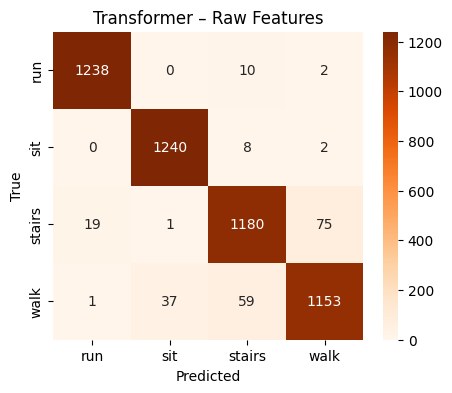


=== Fold 1 ===
Fold 1 | Epoch 10 | Val Loss 0.4592 | Val Acc 0.8706
Fold 1 | Epoch 20 | Val Loss 0.5826 | Val Acc 0.8786
Fold 1 | Epoch 30 | Val Loss 0.5434 | Val Acc 0.8836
Fold 1 | Epoch 40 | Val Loss 0.5913 | Val Acc 0.8965
Fold 1 | Epoch 50 | Val Loss 0.7129 | Val Acc 0.8915
Fold 1 | Epoch 60 | Val Loss 0.6162 | Val Acc 0.8995
Fold 1 | Epoch 70 | Val Loss 0.6621 | Val Acc 0.8995
Fold 1 | Epoch 80 | Val Loss 0.7439 | Val Acc 0.8925
Fold 1 | Epoch 90 | Val Loss 0.7082 | Val Acc 0.8985
Fold 1 | Epoch 100 | Val Loss 0.7379 | Val Acc 0.8935

=== Fold 2 ===
Fold 2 | Epoch 10 | Val Loss 0.8706 | Val Acc 0.8179
Fold 2 | Epoch 20 | Val Loss 0.6531 | Val Acc 0.8378
Fold 2 | Epoch 30 | Val Loss 0.8620 | Val Acc 0.8517
Fold 2 | Epoch 40 | Val Loss 1.2146 | Val Acc 0.8537
Fold 2 | Epoch 50 | Val Loss 1.2436 | Val Acc 0.8438
Fold 2 | Epoch 60 | Val Loss 1.3227 | Val Acc 0.8418
Fold 2 | Epoch 70 | Val Loss 1.3560 | Val Acc 0.8448
Fold 2 | Epoch 80 | Val Loss 1.3267 | Val Acc 0.8498
Fold 2 | Epoc

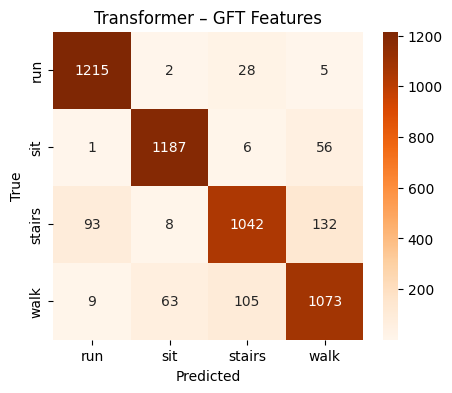

In [8]:
if __name__ == "__main__":
    recordings = load_selected_csvs(DATA_DIR)

    X_raw, y_raw, g_raw = build_dataset(recordings, RAW_FEATURES)
    evaluate_transformer(X_raw, y_raw, g_raw, "Transformer – Raw Features")

    X_gft, y_gft, g_gft = build_dataset(recordings, GFT_FEATURES)
    evaluate_transformer(X_gft, y_gft, g_gft, "Transformer – GFT Features")